We use open, high, low, close but on top of this, let us try to incorporate some volume information too. 

I am separating these two because each group (prices, volumes) have a different kind of plot. And the quantities within those two groups seem to have a similar shape, so I thought it was logical to place them in those two separate categories. 

The plan is to train two models and merge their results to get the final answer. 

In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd
import seaborn as sns
from keras.utils.np_utils import to_categorical


# Load Data

In [2]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape


((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [3]:
train_x_2.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534


In [4]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape

((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [5]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [6]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [7]:
full_df = np.concatenate([x_train, y_train], axis = 1) 
full_df.shape


(7661, 1500, 10)

In [8]:
OHLC = full_df[:,:,[1,2,3,4]] 
OHLC.shape


(7661, 1500, 4)

In [19]:
volume_features = full_df[:,:,[5,6,7,8,9]]
volume_features.shape

(7661, 1500, 5)

# Preprocess Data

In [20]:
K = 120 
N = 30
seq_len = 1500 
features_price = 4 
features_volume = 5 
X_price = [] 
X_volume = []
Y = [] 

for j in tqdm(range(OHLC.shape[0]), position = 0, leave = True): 
    i = 0
    while i+N+K < 1500: 
        X_price.append(OHLC[j, i:i+N, :]) 
        X_volume.append(volume_features[j, i:i+N, :]) 
        Y.append(OHLC[j, i+N+K, 0]) # get open prices as target
        i += 1   
        

X_price = np.asarray(X_price) 
X_volume = np.asarray(X_volume)
Y = np.asarray(Y)

X_price.shape, X_volume.shape, Y.shape

100%|██████████| 7661/7661 [00:16<00:00, 460.77it/s]


((10342350, 30, 4), (10342350, 30, 5), (10342350,))

# Define Model

In [21]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [24]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 4, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output) 
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output) 
    ffn_output = Dense(node, activation = activation)(out1) 
    ffn_output = Dense(node)(ffn_output) 
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2
    
    

def build_transformer(node = 64, activation = 'relu', drop_rate = 0.2, num_layers = 3): 
    time_embedding_price = Time2Vector(N)
    time_embedding_volume = Time2Vector(N)
    ## price transformer 
    price_inputs = Input((N, features_price))  
    bn = BatchNormalization()(price_inputs) 
    x = time_embedding_price(bn) 
    x = Concatenate()([bn, x]) 
    x = Conv1D(node*2, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    x = Conv1D(node, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    positions = tf.range(start=0, limit=x.shape[1], delta=1)
    positions = Embedding(input_dim = x.shape[1], output_dim = node)(positions) 
    x = x + positions 
    for i in range(num_layers): 
        x = transformer_block(x, node, drop_rate, activation)
    x = GlobalMaxPooling1D()(x) 
    
    ## volume transformer 
    volume_inputs = Input((N, features_volume)) 
    bn_v = BatchNormalization()(volume_inputs) 
    x_v = time_embedding_volume(bn_v) 
    x_v = Concatenate()([bn_v, x_v]) 
    x_v = Conv1D(node*2, 5, activation = activation)(x_v) 
    x_v = MaxPooling1D(3)(x_v) 
    x_v = Dropout(drop_rate)(x_v)
    x_v = Conv1D(node, 5, activation = activation)(x_v) 
    x_v = MaxPooling1D(3)(x_v) 
    x_v = Dropout(drop_rate)(x_v)
    positions_v = tf.range(start=0, limit=x_v.shape[1], delta=1) 
    positions_v = Embedding(input_dim=x_v.shape[1], output_dim = node)(positions_v) 
    x_v = x_v + positions_v 
    for i in range(num_layers):  
        x_v = transformer_block(x_v, node, drop_rate, activation)  
    x_v = GlobalMaxPooling1D()(x_v) 
    
    merge = Concatenate()([x, x_v]) 
    blend = Dense(64, activation = 'relu')(merge) 
    blend = BatchNormalization()(blend) 
    outputs = Dense(1, activation = 'relu')(blend) 
    model = Model(inputs=[price_inputs, volume_inputs],outputs=outputs) 
    model.compile(loss = 'mape', optimizer = 'adam', metrics=['mae','mse','mape']) 
    return model


In [25]:
model = build_transformer()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 30, 4)        16          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 30, 5)        20          input_4[0][0]                    
____________________________________________________________________________________________

In [26]:
model_path = 'transformer_price_volume_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit([X_price, X_volume], 
                     Y, 
                     batch_size = 128, 
                     epochs = 50, 
                     callbacks = [learning_rate_reduction, checkpoint], 
                     validation_split = 0.1)


Epoch 1/50
72720/72720 [==============================] - 1407s 19ms/step - loss: 2.0532 - mae: 0.0205 - mse: 0.0043 - mape: 2.0532 - val_loss: 2.3772 - val_mae: 0.0239 - val_mse: 8.9915e-04 - val_mape: 2.3772

Epoch 00001: val_loss improved from inf to 2.37717, saving model to transformer_price_volume_epoch_001_val_2.377.h5
Epoch 2/50
72720/72720 [==============================] - 1393s 19ms/step - loss: 1.1181 - mae: 0.0112 - mse: 3.1387e-04 - mape: 1.1181 - val_loss: 1.5833 - val_mae: 0.0159 - val_mse: 6.0399e-04 - val_mape: 1.5833

Epoch 00002: val_loss improved from 2.37717 to 1.58329, saving model to transformer_price_volume_epoch_002_val_1.583.h5
Epoch 3/50
72720/72720 [==============================] - 1386s 19ms/step - loss: 1.0977 - mae: 0.0110 - mse: 3.0524e-04 - mape: 1.0977 - val_loss: 1.1587 - val_mae: 0.0117 - val_mse: 4.5332e-04 - val_mape: 1.1587

Epoch 00003: val_loss improved from 1.58329 to 1.15865, saving model to transformer_price_volume_epoch_003_val_1.159.h5
Epo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



29858/72720 [===========>..................] - ETA: 13:04 - loss: 1.0716 - mae: 0.0107 - mse: 3.0001e-04 - mape: 1.0716

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50489/72720 [===================>..........] - ETA: 6:46 - loss: 1.0704 - mae: 0.0107 - mse: 2.9829e-04 - mape: 1.0704

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



71610/72720 [============================>.] - ETA: 20s - loss: 1.0695 - mae: 0.0107 - mse: 2.9741e-04 - mape: 1.0695

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20067/72720 [=======>......................] - ETA: 16:02 - loss: 1.0632 - mae: 0.0106 - mse: 2.9744e-04 - mape: 1.0632

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41392/72720 [================>.............] - ETA: 9:33 - loss: 1.0631 - mae: 0.0106 - mse: 2.9643e-04 - mape: 1.0631

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



62528/72720 [========================>.....] - ETA: 3:06 - loss: 1.0631 - mae: 0.0106 - mse: 2.9584e-04 - mape: 1.0631

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19405/72720 [=======>......................] - ETA: 16:15 - loss: 1.0636 - mae: 0.0106 - mse: 2.9688e-04 - mape: 1.0636

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41227/72720 [================>.............] - ETA: 9:36 - loss: 1.0628 - mae: 0.0106 - mse: 2.9567e-04 - mape: 1.0628

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



62409/72720 [========================>.....] - ETA: 3:09 - loss: 1.0623 - mae: 0.0106 - mse: 2.9508e-04 - mape: 1.0623

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11652/72720 [===>..........................] - ETA: 18:27 - loss: 1.0581 - mae: 0.0106 - mse: 2.9327e-04 - mape: 1.0581

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



33465/72720 [============>.................] - ETA: 11:56 - loss: 1.0573 - mae: 0.0106 - mse: 2.9305e-04 - mape: 1.0573

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



55433/72720 [=====================>........] - ETA: 5:15 - loss: 1.0572 - mae: 0.0106 - mse: 2.9313e-04 - mape: 1.0572

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1388s 19ms/step - loss: 1.0572 - mae: 0.0106 - mse: 2.9304e-04 - mape: 1.0572 - val_loss: 1.1238 - val_mae: 0.0113 - val_mse: 4.0264e-04 - val_mape: 1.1238

Epoch 00009: val_loss did not improve from 1.02419
Epoch 10/50
 4567/72720 [>.............................] - ETA: 20:46 - loss: 1.0549 - mae: 0.0106 - mse: 2.9132e-04 - mape: 1.0549

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



29866/72720 [===========>..................] - ETA: 12:56 - loss: 1.0565 - mae: 0.0106 - mse: 2.9156e-04 - mape: 1.0565

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50857/72720 [===================>..........] - ETA: 6:37 - loss: 1.0562 - mae: 0.0106 - mse: 2.9126e-04 - mape: 1.0562

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72551/72720 [============================>.] - ETA: 3s - loss: 1.0558 - mae: 0.0106 - mse: 2.9107e-04 - mape: 1.0558

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20763/72720 [=======>......................] - ETA: 15:46 - loss: 1.0537 - mae: 0.0105 - mse: 2.9149e-04 - mape: 1.0537

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



42470/72720 [================>.............] - ETA: 9:10 - loss: 1.0530 - mae: 0.0105 - mse: 2.9115e-04 - mape: 1.0530

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



63493/72720 [=========================>....] - ETA: 2:48 - loss: 1.0530 - mae: 0.0105 - mse: 2.9129e-04 - mape: 1.0530

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11572/72720 [===>..........................] - ETA: 18:33 - loss: 1.0414 - mae: 0.0104 - mse: 2.8832e-04 - mape: 1.0414

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



32229/72720 [============>.................] - ETA: 12:18 - loss: 1.0384 - mae: 0.0104 - mse: 2.8610e-04 - mape: 1.0384

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



53367/72720 [=====================>........] - ETA: 5:53 - loss: 1.0375 - mae: 0.0104 - mse: 2.8517e-04 - mape: 1.0375

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1385s 19ms/step - loss: 1.0371 - mae: 0.0104 - mse: 2.8472e-04 - mape: 1.0371 - val_loss: 1.0317 - val_mae: 0.0104 - val_mse: 3.9555e-04 - val_mape: 1.0317

Epoch 00012: val_loss did not improve from 1.02419
Epoch 13/50
 1762/72720 [..............................] - ETA: 21:43 - loss: 1.0287 - mae: 0.0103 - mse: 2.7523e-04 - mape: 1.0287

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23152/72720 [========>.....................] - ETA: 15:09 - loss: 1.0340 - mae: 0.0103 - mse: 2.8132e-04 - mape: 1.0340

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



57030/72720 [======================>.......] - ETA: 4:45 - loss: 1.0345 - mae: 0.0104 - mse: 2.8198e-04 - mape: 1.0345

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1384s 19ms/step - loss: 1.0345 - mae: 0.0104 - mse: 2.8197e-04 - mape: 1.0345 - val_loss: 1.0536 - val_mae: 0.0106 - val_mse: 3.9193e-04 - val_mape: 1.0536

Epoch 00013: val_loss did not improve from 1.02419
Epoch 14/50
 5455/72720 [=>............................] - ETA: 20:31 - loss: 1.0378 - mae: 0.0104 - mse: 2.8514e-04 - mape: 1.0378

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27385/72720 [==========>...................] - ETA: 13:48 - loss: 1.0349 - mae: 0.0104 - mse: 2.8209e-04 - mape: 1.0349

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



49572/72720 [===================>..........] - ETA: 7:01 - loss: 1.0346 - mae: 0.0104 - mse: 2.8186e-04 - mape: 1.0346

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



71769/72720 [============================>.] - ETA: 17s - loss: 1.0344 - mae: 0.0104 - mse: 2.8180e-04 - mape: 1.0344

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21526/72720 [=======>......................] - ETA: 15:35 - loss: 1.0346 - mae: 0.0104 - mse: 2.8247e-04 - mape: 1.0346

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43034/72720 [================>.............] - ETA: 9:03 - loss: 1.0344 - mae: 0.0104 - mse: 2.8230e-04 - mape: 1.0344

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



64912/72720 [=========================>....] - ETA: 2:23 - loss: 1.0342 - mae: 0.0104 - mse: 2.8202e-04 - mape: 1.0342

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14160/72720 [====>.........................] - ETA: 17:53 - loss: 1.0303 - mae: 0.0103 - mse: 2.7712e-04 - mape: 1.0303

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36807/72720 [==============>...............] - ETA: 10:54 - loss: 1.0318 - mae: 0.0103 - mse: 2.7912e-04 - mape: 1.0318

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



58446/72720 [=======================>......] - ETA: 4:19 - loss: 1.0322 - mae: 0.0103 - mse: 2.7965e-04 - mape: 1.0322

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1376s 19ms/step - loss: 1.0324 - mae: 0.0103 - mse: 2.7988e-04 - mape: 1.0324 - val_loss: 1.0254 - val_mae: 0.0103 - val_mse: 3.6964e-04 - val_mape: 1.0254

Epoch 00016: val_loss did not improve from 1.01648
Epoch 17/50
 6679/72720 [=>............................] - ETA: 19:56 - loss: 1.0343 - mae: 0.0104 - mse: 2.8227e-04 - mape: 1.0343

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27799/72720 [==========>...................] - ETA: 13:41 - loss: 1.0328 - mae: 0.0103 - mse: 2.8130e-04 - mape: 1.0328

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



49371/72720 [===================>..........] - ETA: 7:07 - loss: 1.0328 - mae: 0.0103 - mse: 2.8133e-04 - mape: 1.0328

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



70428/72720 [============================>.] - ETA: 41s - loss: 1.0327 - mae: 0.0103 - mse: 2.8127e-04 - mape: 1.0327

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19555/72720 [=======>......................] - ETA: 16:09 - loss: 1.0337 - mae: 0.0103 - mse: 2.8216e-04 - mape: 1.0337

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1389s 19ms/step - loss: 1.0333 - mae: 0.0103 - mse: 2.8108e-04 - mape: 1.0333 - val_loss: 1.1515 - val_mae: 0.0115 - val_mse: 3.8688e-04 - val_mape: 1.1515

Epoch 00018: val_loss did not improve from 0.98782
Epoch 19/50
21313/72720 [=======>......................] - ETA: 15:40 - loss: 1.0323 - mae: 0.0103 - mse: 2.7953e-04 - mape: 1.0323

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



42694/72720 [================>.............] - ETA: 9:08 - loss: 1.0320 - mae: 0.0103 - mse: 2.7957e-04 - mape: 1.0320

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35686/72720 [=============>................] - ETA: 11:16 - loss: 1.0314 - mae: 0.0103 - mse: 2.8121e-04 - mape: 1.0314

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



56764/72720 [======================>.......] - ETA: 4:52 - loss: 1.0314 - mae: 0.0103 - mse: 2.8114e-04 - mape: 1.0314

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1386s 19ms/step - loss: 1.0313 - mae: 0.0103 - mse: 2.8105e-04 - mape: 1.0313 - val_loss: 1.0010 - val_mae: 0.0101 - val_mse: 3.7659e-04 - val_mape: 1.0010

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00020: val_loss did not improve from 0.98782
Epoch 21/50
 5410/72720 [=>............................] - ETA: 20:24 - loss: 1.0241 - mae: 0.0102 - mse: 2.7491e-04 - mape: 1.0241

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



26401/72720 [=========>....................] - ETA: 14:03 - loss: 1.0241 - mae: 0.0102 - mse: 2.7643e-04 - mape: 1.0241

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



47356/72720 [==================>...........] - ETA: 7:42 - loss: 1.0243 - mae: 0.0103 - mse: 2.7698e-04 - mape: 1.0243

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1388s 19ms/step - loss: 1.0241 - mae: 0.0102 - mse: 2.7685e-04 - mape: 1.0241 - val_loss: 1.0151 - val_mae: 0.0102 - val_mse: 3.5822e-04 - val_mape: 1.0151

Epoch 00021: val_loss did not improve from 0.98782
Epoch 22/50
72720/72720 [==============================] - 1390s 19ms/step - loss: 1.0229 - mae: 0.0102 - mse: 2.7564e-04 - mape: 1.0229 - val_loss: 1.0543 - val_mae: 0.0106 - val_mse: 3.7267e-04 - val_mape: 1.0543

Epoch 00022: val_loss did not improve from 0.98782
Epoch 23/50
72720/72720 [==============================] - 1387s 19ms/step - loss: 1.0233 - mae: 0.0102 - mse: 2.7571e-04 - mape: 1.0233 - val_loss: 1.0387 - val_mae: 0.0104 - val_mse: 3.4174e-04 - val_mape: 1.0387

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00023: val_loss did not improve from 0.98782
Epoch 24/50
46665/72720 [==================>...........] - ETA: 7:55 - loss: 1.0197 - mae: 0.0102 - mse: 2.7470e-04 - mape: 1.0197

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



71979/72720 [============================>.] - ETA: 13s - loss: 1.0195 - mae: 0.0102 - mse: 2.7431e-04 - mape: 1.0195

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23966/72720 [========>.....................] - ETA: 14:53 - loss: 1.0208 - mae: 0.0102 - mse: 2.7519e-04 - mape: 1.0208

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



49215/72720 [===================>..........] - ETA: 7:09 - loss: 1.0200 - mae: 0.0102 - mse: 2.7470e-04 - mape: 1.0200

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1390s 19ms/step - loss: 1.0198 - mae: 0.0102 - mse: 2.7444e-04 - mape: 1.0198 - val_loss: 1.0050 - val_mae: 0.0101 - val_mse: 3.3197e-04 - val_mape: 1.0050

Epoch 00025: val_loss did not improve from 0.98782
Epoch 26/50
  961/72720 [..............................] - ETA: 21:10 - loss: 1.0124 - mae: 0.0101 - mse: 2.7276e-04 - mape: 1.0124

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19054/72720 [======>.......................] - ETA: 16:14 - loss: 1.0174 - mae: 0.0102 - mse: 2.7351e-04 - mape: 1.0174

KeyboardInterrupt: 

# Make prediction

In [27]:
best_model = load_model('transformer_price_volume_epoch_017_val_0.988.h5', custom_objects = {'Time2Vector':Time2Vector})
best_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 30, 4)        16          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 30, 5)        20          input_4[0][0]                    
____________________________________________________________________________________________

In [29]:
X_test_price = [] 
X_test_volume = []

for j in tqdm(range(x_test.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-K-N-120, seq_len-K-N):
        X_test_price.append(x_test[j, i:i+N, [1,2,3,4]])  
        X_test_volume.append(x_test[j, i:i+N, [5,6,7,8,9]])

X_test_price = np.asarray(X_test_price) 
X_test_volume = np.asarray(X_test_volume) 

X_test_price = X_test_price.reshape((-1,N,features_price)) 
X_test_volume = X_test_volume.reshape((-1,N,features_volume))

X_test_price.shape, X_test_volume.shape


100%|██████████| 535/535 [00:00<00:00, 986.82it/s]


((64200, 30, 4), (64200, 30, 5))

In [30]:
predicted = best_model.predict([X_test_price, X_test_volume]) 
predicted = predicted.reshape((-1,120)) 
predicted.shape


(535, 120)

In [31]:
x_test_open = x_test[:,:,1] 

## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(predicted.shape[0]), position = 0, leave = True):
    buy_price = x_test_open[i,-1] 
    if predicted[i,0] > buy_price:
        diff = predicted[i,0] - buy_price 
        predicted[i,:] -= diff 
    elif predicted[i,0] < buy_price:  
        diff = buy_price - predicted[i,0] 
        predicted[i,:] += diff


100%|██████████| 535/535 [00:00<00:00, 133927.34it/s]


In [32]:
## create submission dataframe version 1 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_open[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('transformers_full_features.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 4288.88it/s]


In [33]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.850000,105
1,7662,1.000000,54
2,7663,0.966667,106
3,7664,0.341667,23
4,7665,0.841667,56
...,...,...,...
530,8191,0.016667,1
531,8192,0.016667,4
532,8193,0.741667,93
533,8194,0.133333,14


In [34]:
pred_train = best_model.predict([X_price[:3600,], X_volume[:3600,]])
pred_train = pred_train.reshape((-1,120))
pred_train.shape


(30, 120)

In [35]:
x_train_open = x_train[:,:,1]

for i in tqdm(range(pred_train.shape[0]), position = 0, leave = True): 
    buy_price = x_train_open[i,-1] 
    if pred_train[i,0] > buy_price:
        diff = pred_train[i,0] - buy_price 
        pred_train[i,:] -= diff 
    elif pred_train[i,0] < buy_price:  
        diff = buy_price - pred_train[i,0] 
        pred_train[i,:] += diff


100%|██████████| 30/30 [00:00<00:00, 66052.03it/s]


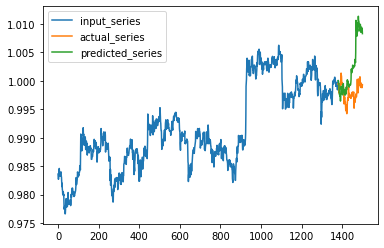

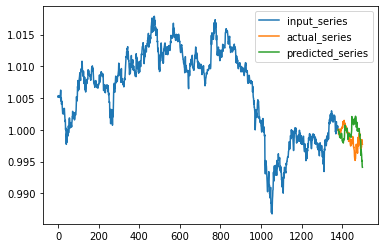

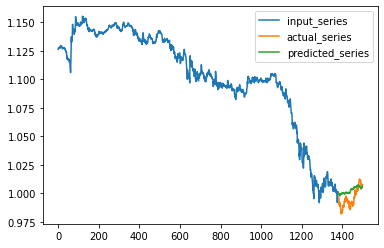

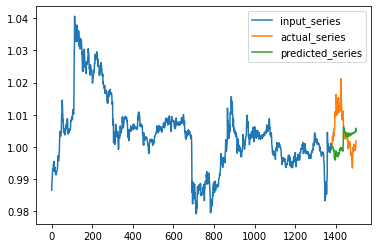

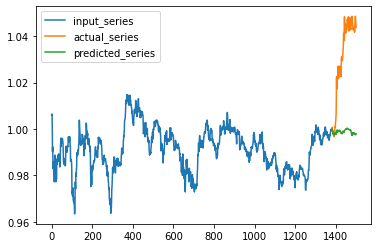

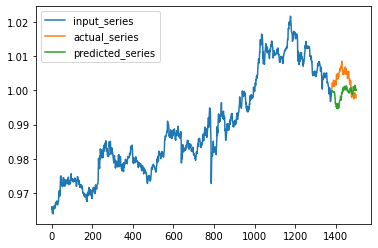

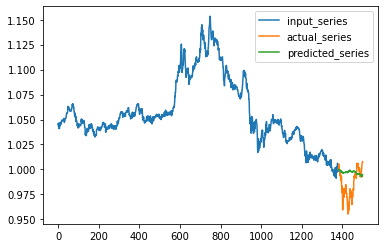

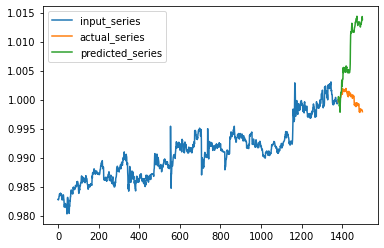

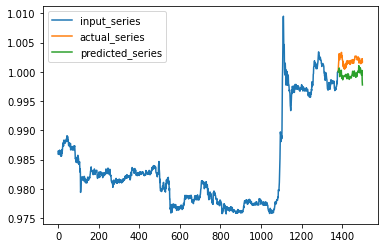

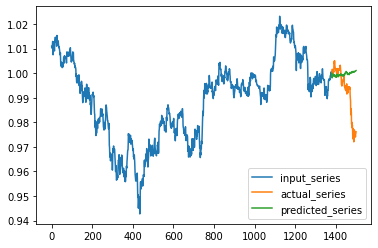

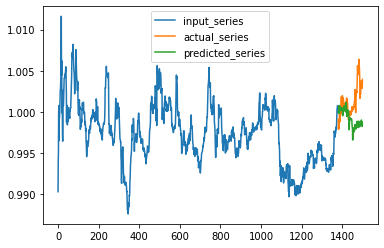

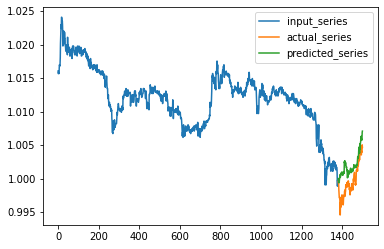

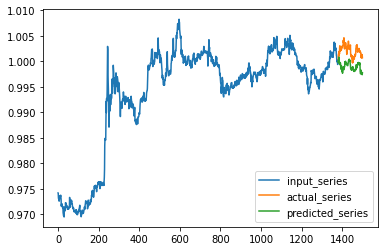

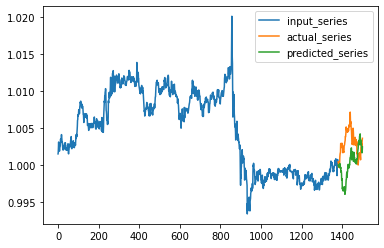

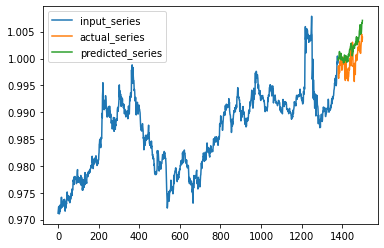

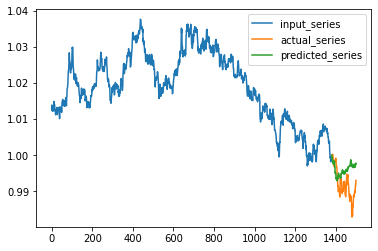

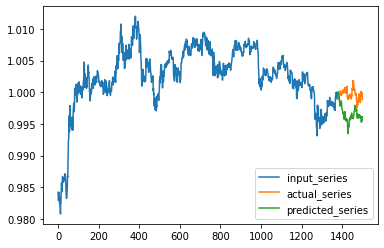

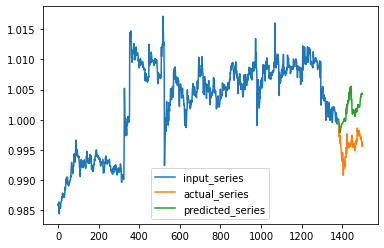

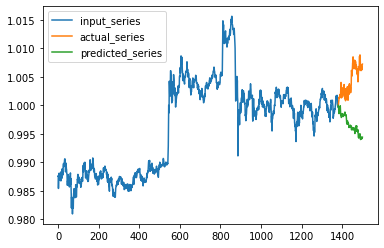

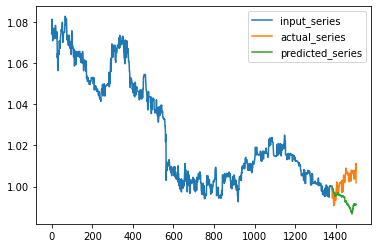

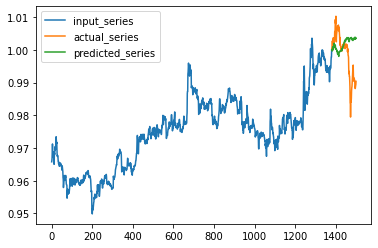

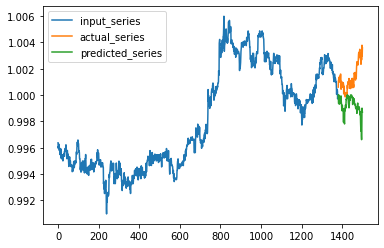

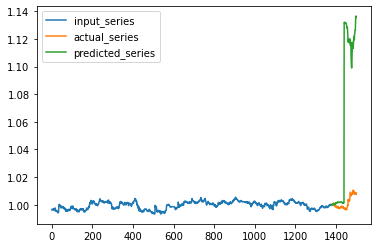

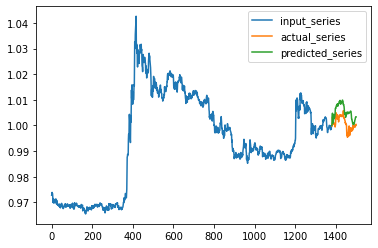

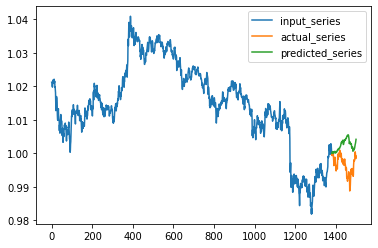

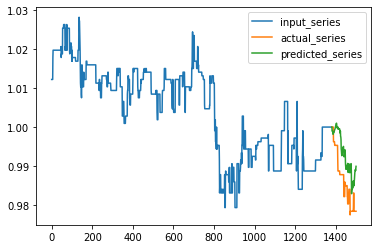

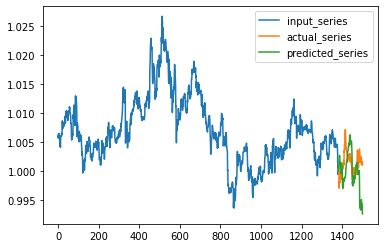

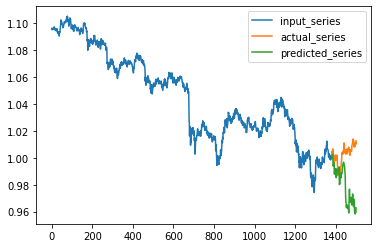

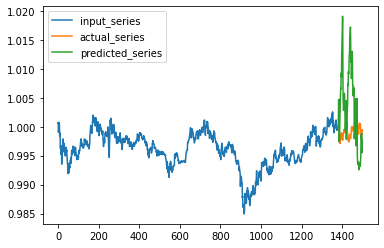

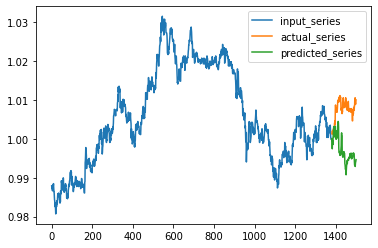

In [36]:
y_train_open = y_train[:,:,1]

for i in range(30): 
    plt.plot() 
    plot_series(x_train_open[i,:], y_train_open[i,:], pred_train[i,:])
    plt.show()
